# single spot coverage

In [ ]:
# crick env

import sys
import subprocess
import os
from concurrent import futures
from functools import partial
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [ ]:
work_dir='/home/goubo/CRICK/CRICK/spaceA/single_cov'

assemble='mm10'
os.makedirs(work_dir,exist_ok=True)
os.chdir(work_dir)

chr_size_path='/home/goubo/reference/index/star'
final_samples=['E11.5L1','E11.5L2','E12.5L5','E12.5L6','E13.5C1','E13.5C4','E13.5C6','E14.5F5','E14.5F6']


In [ ]:

# subprocess.call(f"bedtools makewindows -g {chr_size_path}/{assemble}/{assemble}.mainchr.sizes \
#                 -w 1000000 -s 1000000 -b > {chr_size_path}/{assemble}/chr_1MB.bed", shell=True)
# subprocess.call(f"bedtools makewindows -g {chr_size_path}/{assemble}/{assemble}.mainchr.sizes \
#                 -w 10000 -s 10000 -b > {chr_size_path}/{assemble}/chr_10kb.bed", shell=True)
# subprocess.call(f"bedtools makewindows -g {chr_size_path}/{assemble}/{assemble}.mainchr.sizes \
#                 -w 50000 -s 50000 -b > {chr_size_path}/{assemble}/chr_50kb.bed", shell=True)
# subprocess.call(f"bedtools makewindows -g {chr_size_path}/{assemble}/{assemble}.mainchr.sizes \
#                 -w 100000 -s 100000 -b > {chr_size_path}/{assemble}/chr_100kb.bed", shell=True)


In [ ]:

def get_spot_cluster_cov(spot,single_cluster_dir,out_dir):

    cluster_f=os.path.join(single_cluster_dir,spot)
    cluster_tmp_bed=os.path.join(out_dir,cluster_f+'.tmp.bed')
    cluster_tmp_sort_bed=os.path.join(out_dir,cluster_f+'.sort.bed')

    coverage_bed_10kb=os.path.join(out_dir,f'{spot}_10kb.coverage.bed')
    coverage_bed_50kb=os.path.join(out_dir,f'{spot}_50kb.coverage.bed')
    coverage_bed_100kb=os.path.join(out_dir,f'{spot}_100kb.coverage.bed')
    coverage_bed_1MB=os.path.join(out_dir,f'{spot}_1MB.coverage.bed')

    if not os.path.exists(coverage_bed_1MB+'.gz'):
        # cluster to bed
        with open(cluster_f,'r') as in_f,open(cluster_tmp_bed,'w') as out_f:
            for line in in_f:
                reads=line.strip().split('\t')[1:]
                cluster_length=len(reads)
                # if 2 <= cluster_length <= 10000:
                for read in reads:
                    chr=read.split(']_')[1].split(':')[0] #scCRICK[-]_chr11:51844252-52160457
                    start,end=read.split(':')[1].split('-')
                    out_f.write(chr+'\t'+start+'\t'+end+'\n')

        subprocess.run(f"sort -k1,1V -k2,2n -k3,3n {cluster_tmp_bed} > {cluster_tmp_sort_bed}", shell=True)

        subprocess.run(f"bedtools coverage -a {chr_size_path}/{assemble}/chr_10kb.bed \
                        -b {cluster_tmp_sort_bed} > {coverage_bed_10kb}", shell=True)
        
        subprocess.run(f"bedtools coverage -a {chr_size_path}/{assemble}/chr_50kb.bed \
                        -b {cluster_tmp_sort_bed} > {coverage_bed_50kb}", shell=True)
        
        subprocess.run(f"bedtools coverage -a {chr_size_path}/{assemble}/chr_100kb.bed \
                        -b {cluster_tmp_sort_bed} > {coverage_bed_100kb}", shell=True)
        
        subprocess.run(f"bedtools coverage -a {chr_size_path}/{assemble}/chr_1MB.bed \
                        -b {cluster_tmp_sort_bed} > {coverage_bed_1MB}", shell=True)
        
        subprocess.run(f"gzip -f {coverage_bed_10kb}", shell=True)
        subprocess.run(f"gzip -f {coverage_bed_50kb}", shell=True)
        subprocess.run(f"gzip -f {coverage_bed_100kb}", shell=True)
        subprocess.run(f"gzip -f {coverage_bed_1MB}", shell=True)

        subprocess.run(f"/bin/rm -rf {cluster_tmp_bed}", shell=True)
        subprocess.run(f"/bin/rm -rf {cluster_tmp_sort_bed}", shell=True)
        
    # print(f'\n{spot} is done!')


In [ ]:
for sample in final_samples:
    single_cluster_dir=f'/home/goubo/CRICK/CRICK/spaceA/cluster/clusters_{sample}_single_filtered'

    spot_infor_f=f'/home/goubo/CRICK/CRICK/spaceA/higashi_v2/higashi/{sample}/{sample}_higashi_obs_new.csv'
    spot_infor=pd.read_csv(spot_infor_f)
    spot_lst=spot_infor.spot_id.to_list()

    out_path=os.path.join(work_dir,sample)
    os.makedirs(out_path,exist_ok=True)

    with futures.ProcessPoolExecutor(max_workers=30) as pool:
        func = partial(get_spot_cluster_cov,single_cluster_dir=single_cluster_dir,out_dir=out_path)
        res=list(tqdm(pool.map(func,spot_lst), total=len(spot_lst)))

    print(f'\n{sample} is done!')

In [ ]:
cov_col_names=['chr','start','end','depth','bases','size','fraction']
reso_lst=['1MB','100kb','50kb','10kb'] 

def get_spot_pos_bin_fract(spot,cov_col_names, sample, sample_path, reso):
    sample_path=os.path.join(work_dir,sample)
    cov_bed=os.path.join(sample_path,f'{spot}_{reso}.coverage.bed.gz')
    cov_tmp=pd.read_table(cov_bed,names=cov_col_names)
    spot_pos_bin_fract=sum(cov_tmp['fraction'] > 0)/len(cov_tmp['fraction'])
    return spot_pos_bin_fract

spot_pos_bin_fract_df_f='spot_pos_bin_fract.csv'
if not os.path.exists(spot_pos_bin_fract_df_f):
    spot_pos_bin_fract_df=pd.DataFrame()
    for sample in final_samples:
        print(sample+'\n')
        spot_infor_f=f'/home/goubo/CRICK/CRICK/spaceA/higashi_v2/higashi/{sample}/{sample}_higashi_obs_new.csv'
        spot_infor=pd.read_csv(spot_infor_f)
        spot_lst=spot_infor.spot_id.to_list()
        sample_path=os.path.join(work_dir,sample)
        for reso in reso_lst:
            print(reso+'\n')
            with futures.ProcessPoolExecutor(max_workers=64) as pool:
                func = partial(get_spot_pos_bin_fract,cov_col_names=cov_col_names, sample=sample,
                                sample_path=sample_path, reso=reso)
                res=tqdm(pool.map(func,spot_lst), total=len(spot_lst))
                spot_pos_bin_fract_tmp=pd.DataFrame()
                spot_pos_bin_fract_tmp['spot_id']=spot_lst
                spot_pos_bin_fract_tmp['pos_bin_fract']=list(res)
                spot_pos_bin_fract_tmp['sample']=sample
                spot_pos_bin_fract_tmp['reso']=reso
                spot_pos_bin_fract_df=pd.concat([spot_pos_bin_fract_df,spot_pos_bin_fract_tmp],axis=0)
    spot_pos_bin_fract_df.to_csv(spot_pos_bin_fract_df_f)
else:
    spot_pos_bin_fract_df=pd.read_csv(spot_pos_bin_fract_df_f)

In [ ]:
spot_pos_bin_fract_df.head()

In [ ]:
spot_pos_bin_fract_df_sort=spot_pos_bin_fract_df.sort_values(['sample','pos_bin_fract'],ascending=[True,False])

In [ ]:
grid = sns.FacetGrid(data=spot_pos_bin_fract_df_sort, col='sample',col_wrap=3,
                     sharex=False,sharey=False,aspect=2,height=2)
grid.map_dataframe(sns.lineplot, x="pos_bin_fract",y="spot_id",hue='reso')
grid.tick_params(left=False, labelleft=False)
grid.add_legend()
grid.tight_layout()
grid.set_xlabels('Frequency of bins covered')
grid.set_ylabels('Spot ID')
grid.savefig("Single-cell_coverage_plot.pdf")

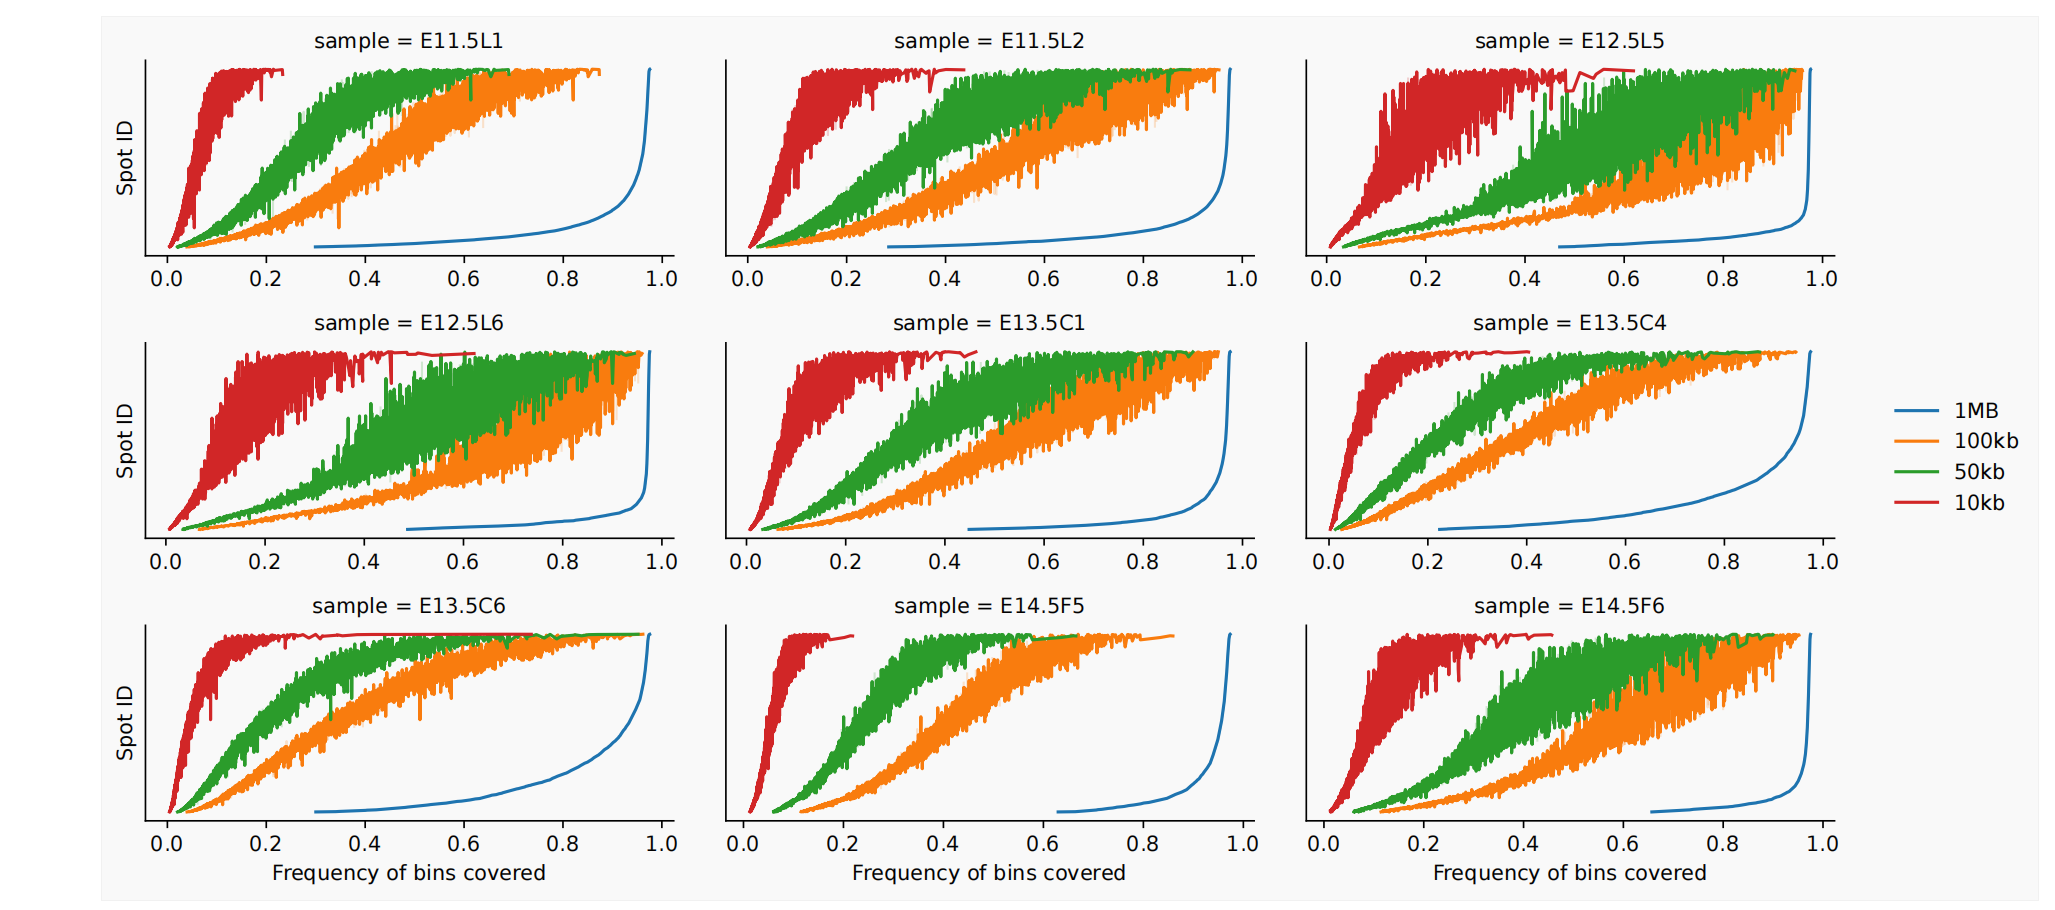